<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Drowsiness-Detection/blob/main/Drowsiness_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drowsiness Detection

This project uses segmented eyes images to classify them into open or closed.
The Data was obtained from [kaggle](https://www.kaggle.com/prasadvpatil/mrl-dataset).

## Steps:
1.  Imports
2.  Load Data
3.  Create Model
4.  Train Model
5.  Prediction of Real Images

## Imports

In [390]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

## Load Data

In [8]:
# Locating the data

train_path = '/content/drive/MyDrive/Drowsiness Detection/Dataset/train/'
sample_img = plt.imread(train_path + 'Closed_Eyes/s0001_00003_0_0_0_0_0_01.png')

In [9]:
def display_img(img):
  """
  Takes an image as input and displays it using `matplotlib.pyplot.imshow`.
  """
  plt.imshow(img, cmap = 'gray')
  plt.axis('off');


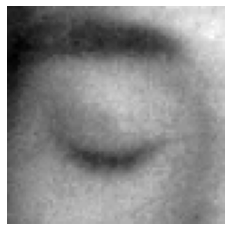

In [10]:
display_img(sample_img)

In [15]:
sample_img.min(), sample_img.max()

(0.15686275, 0.39607844)

In [20]:
sample_img.shape

(81, 81)

In [134]:
# Loading all images

train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range=0.1, 
                               brightness_range=[0.5,1.3],
                               fill_mode = 'nearest',
                               rescale = 1/255
                              )

In [135]:
train_img_gen = train_gen.flow_from_directory(train_path, 
                                              target_size=(224,224), 
                                              color_mode='rgb', 
                                              class_mode='binary')
                                              

Found 4000 images belonging to 2 classes.


## Create Model

In [164]:
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'
INPUT_SHAPE = (None,224,224,3)

In [165]:
# Function to build a CNN model

def create_model(input_shape = INPUT_SHAPE, model_url = MODEL_URL):
  
  print("Building model with:", MODEL_URL)
  
  # Set up model layers
  model = tf.keras.models.Sequential([
          hub.KerasLayer(model_url), # Layer 1
          tf.keras.layers.Dense(1, activation = 'sigmoid') # Layer 2
  ])
    
  # Compile the model
  model.compile( 
      loss = tf.keras.losses.BinaryCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
      )
  
  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [166]:
model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


## Train Model

In [168]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1002      
Total params: 5,433,715
Trainable params: 1,002
Non-trainable params: 5,432,713
_________________________________________________________________


In [169]:
model.fit(train_img_gen, verbose = 2)

125/125 - 1391s - loss: 0.0774 - accuracy: 0.9755


## Prediction on Real Images

All images for testing were obtained from [pixabay](https://pixabay.com/photos/)

In [331]:
train_img_gen.class_indices

{'Closed_Eyes': 0, 'Open_Eyes': 1}

LABELS
-  'Closed_Eyes': 0
-  'Open_Eyes': 1

array([[0.00115576]], dtype=float32)

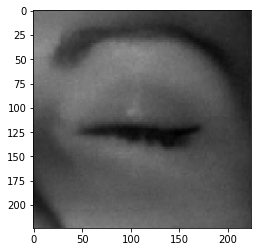

In [329]:
temp = train_img_gen[0][0][6].copy()
plt.imshow(temp)
temp = np.expand_dims(temp, axis = 0)
model.predict(temp)

array([[0.8043246]], dtype=float32)

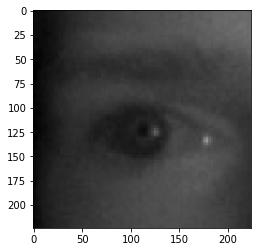

In [330]:
temp = train_img_gen[0][0][5].copy()
plt.imshow(temp)
temp = np.expand_dims(temp, axis = 0)
model.predict(temp)

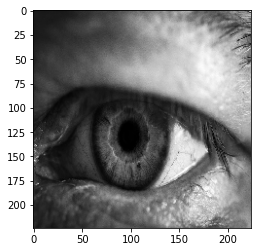

In [327]:
test_img = load_img('/content/sample_data/eyeball-3235020_640.jpg', target_size=(224, 224))
test_img = img_to_array(test_img)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
temp2 = test_img.copy()
temp = test_img.copy()
temp = np.zeros((224,224,3))
temp[:,:,0] = temp2
temp[:,:,1] = temp2
temp[:,:,2] = temp2
temp = temp/255
plt.imshow(temp)
temp = np.expand_dims(temp, axis = 0)


In [328]:
model.predict(temp)

array([[0.9984871]], dtype=float32)

In [345]:
def preprocess_test(img_path):
  """
  Takes in image path.
  Prepares image for feeding it to the model.predict function
  to get a prediction.
  """

  img = cv2.imread(img_path)

  # Detect Eyes
  eyes_roi = []
  eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # plt.imshow(gray)
  eyes = eyeCascade.detectMultiScale(gray, 1.1, 4)
  # print(eyes)
  for i,(ex, ey, ew, eh) in enumerate(eyes) :
        eyes_roi.append(gray[ey:ey+eh, ex-20:ex+ew-20])
  
  eye_imgs = []
  for i,eye_img in enumerate(eyes_roi):
    eye_img = cv2.resize(eye_img, (224,224))
    temp = np.zeros((224,224,3))
    temp[:,:,0] = eye_img
    temp[:,:,1] = eye_img
    temp[:,:,2] = eye_img
    temp = temp/255
    eye_imgs.append(temp) 
  # eye_imgs = np.expand_dims(eye_imgs, axis = 0)
  return np.array(eye_imgs)
  


In [346]:
test_eyes = preprocess_test('/content/sample_data/blue-1382940_640.jpg')

In [347]:
test_eyes.shape

(3, 224, 224, 3)

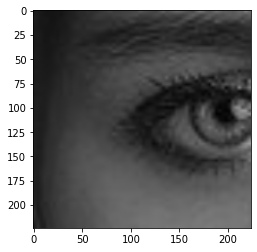

In [348]:
plt.imshow(test_eyes[1])

In [350]:
model.predict(test_eyes)

array([[0.68609273],
       [0.8229004 ],
       [0.02674496]], dtype=float32)

In [308]:
test_eyes = preprocess_test('/content/sample_data/woman-1919143_640.jpg')

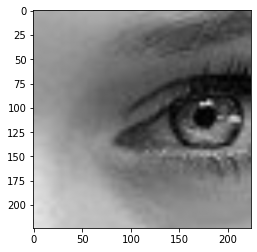

In [313]:
plt.imshow(test_eyes[2])

In [314]:
model.predict(test_eyes)

array([[0.01608229],
       [0.998765  ],
       [0.96663505]], dtype=float32)

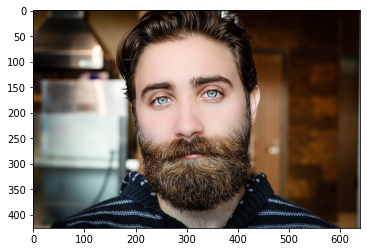

In [365]:
img_path = '/content/drive/MyDrive/Drowsiness Detection/Dataset/downloaded_test/beard-1845166_640.jpg'
plt.imshow(imread(img_path))

In [366]:
test_eyes = preprocess_test(img_path)
test_eyes.shape

(2, 224, 224, 3)

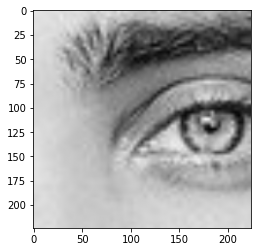

In [369]:
plt.imshow(test_eyes[0])

In [370]:
model.predict(test_eyes)

array([[0.58238107],
       [0.53494686]], dtype=float32)

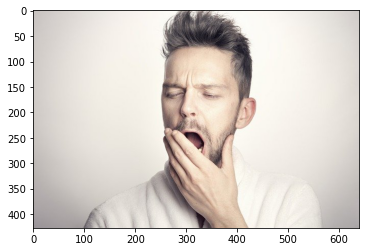

In [371]:
img_path = '/content/drive/MyDrive/Drowsiness Detection/Dataset/downloaded_test/man-5522892_640.jpg'
plt.imshow(imread(img_path))

In [372]:
test_eyes = preprocess_test(img_path)
test_eyes.shape

(1, 224, 224, 3)

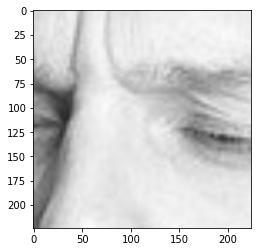

In [373]:
plt.imshow(test_eyes[0])

In [374]:
model.predict(test_eyes)

array([[0.03243622]], dtype=float32)

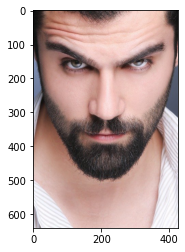

In [383]:
img_path = '/content/drive/MyDrive/Drowsiness Detection/Dataset/downloaded_test/man-657869_640.jpg'
plt.imshow(imread(img_path))

In [384]:
test_eyes = preprocess_test(img_path)
test_eyes.shape

(2, 224, 224, 3)

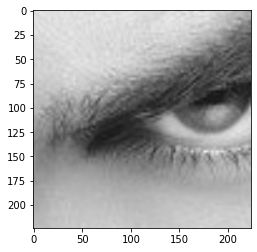

In [386]:
plt.imshow(test_eyes[1])

In [388]:
# Wrong Classification
model.predict(test_eyes)

array([[0.03113911],
       [0.03633606]], dtype=float32)